In [19]:
from model import TIPINN_Cooling
import matplotlib.pyplot as plt
from copy import deepcopy

# Train Models

In [2]:
epochs = 15_000
params = [
    {"phys_loss": False, "topo_loss": True, "ols_loss": True, "lr":1e-5, "epochs":epochs, "ols_loss_weight": 0.5},
    {"phys_loss": True, "topo_loss": False, "ols_loss": False, "lr":1e-5, "epochs":epochs},
    {"phys_loss": False, "topo_loss": True, "ols_loss": False, "lr":1e-5, "epochs":epochs}
]
records = []
for param in params:
    cooling = TIPINN_Cooling(**param)
    losses = cooling.fit(cooling.approx_times, cooling.approx_temps)
    predict = cooling.predict(cooling.true_times)
    data = param | {'losses': losses, 'prediction': predict, 'times': cooling.true_times, "states": deepcopy(cooling.state_dict())}
    records.append(data)

/home/codespace/.python/current/lib/python3.10/site-packages/ot/lp/__init__.py:107: RuntimeWarning: invalid value encountered in scalar divide
  c = (b.dot(beta0) - a.dot(alpha0)) / (a.sum() + b.sum())
/home/codespace/.python/current/lib/python3.10/site-packages/ot/lp/__init__.py:547: UserWarning: Problem infeasible. Check that a and b are in the simplex
  check_result(result_code)


Epoch 0/15000, loss: 16072.81
Epoch 1500/15000, loss: 14902.92
Epoch 3000/15000, loss: 13745.92
Epoch 4500/15000, loss: 12495.17
Epoch 6000/15000, loss: 11729.77
Epoch 7500/15000, loss: 11117.70
Epoch 9000/15000, loss: 10604.37
Epoch 10500/15000, loss: 10109.70
Epoch 12000/15000, loss: 9630.65
Epoch 13500/15000, loss: 9167.42
Epoch 0/15000, loss: 3668.91
Epoch 1500/15000, loss: 1662.19
Epoch 3000/15000, loss: 1310.27
Epoch 4500/15000, loss: 551.22
Epoch 6000/15000, loss: 93.14
Epoch 7500/15000, loss: 4.21
Epoch 9000/15000, loss: 2.08
Epoch 10500/15000, loss: 1.91
Epoch 12000/15000, loss: 1.80
Epoch 13500/15000, loss: 1.67
Epoch 0/15000, loss: 3217.24
Epoch 1500/15000, loss: 1637.47
Epoch 3000/15000, loss: 1316.95
Epoch 4500/15000, loss: 585.04
Epoch 6000/15000, loss: 92.56
Epoch 7500/15000, loss: 12.17
Epoch 9000/15000, loss: 9.72
Epoch 10500/15000, loss: 8.26
Epoch 12000/15000, loss: 6.75
Epoch 13500/15000, loss: 4.76


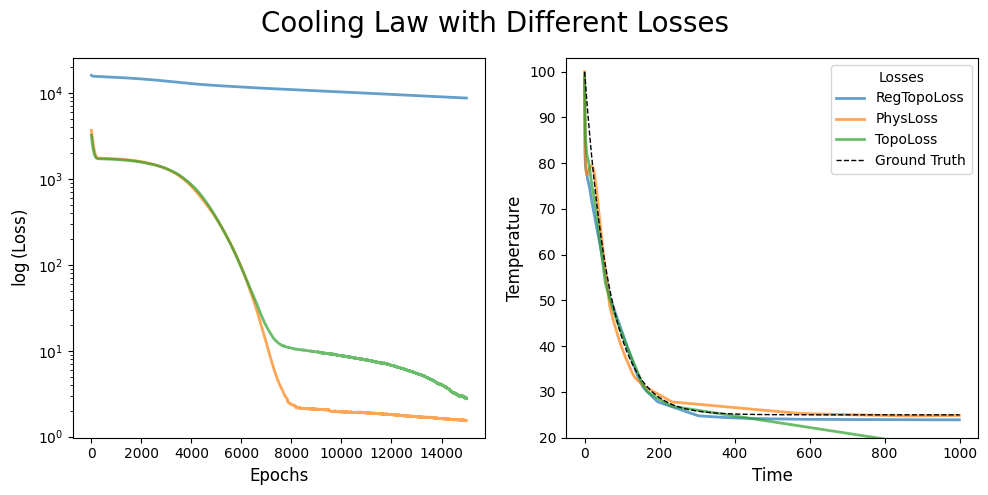

In [18]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5 ))
for record in records:
    xs = range(len(record['losses']))
    ys = range(len(record['prediction']))
    if record['phys_loss']:
        label = 'PhysLoss'
    else:
        if not record['ols_loss']:
            label = "TopoLoss"
        else:
            label = "RegTopoLoss"
    ax[0].plot(xs, record['losses'], label = label, lw = 2, alpha = 0.7)
    ax[1].plot(ys, record['prediction'].numpy().flatten(), label = label, lw = 2, alpha = 0.7)

ax[0].set_ylabel("$\log$(Loss)", fontsize = 12)
ax[0].set_xlabel("Epochs", fontsize = 12)
ax[0].set_yscale('log')

ax[1].set_ylabel('Temperature', fontsize = 12)
ax[1].set_xlabel("Time", fontsize = 12)
ax[1].plot(record['times'], cooling.true_temps, label = 'Ground Truth', lw = 1, color = 'black', linestyle = '--')
ax[1].legend(title = 'Losses')
ax[1].set_ylim([20, 103])
plt.suptitle("Cooling Law with Different Losses", fontsize = 20)
plt.tight_layout()
plt.savefig("./imgs/cooling_law_with_diff_losses.png")
plt.show()

# Look at predictions for varying noise levels

In [20]:
epochs = 10_000
noise_params = [
    {"phys_loss": False, "topo_loss": True, "ols_loss": True, "lr":1e-5, "epochs":epochs, "ols_loss_weight": 0.5, "noise_intensity": 2},
    {"phys_loss": True, "topo_loss": False, "ols_loss": False, "lr":1e-5, "epochs":epochs, "noise_intensity": 2},
    {"phys_loss": False, "topo_loss": True, "ols_loss": True, "lr":1e-5, "epochs":epochs, "ols_loss_weight": 0.5, "noise_intensity": 4},
    {"phys_loss": True, "topo_loss": False, "ols_loss": False, "lr":1e-5, "epochs":epochs, "noise_intensity": 4},
    {"phys_loss": False, "topo_loss": True, "ols_loss": True, "lr":1e-5, "epochs":epochs, "ols_loss_weight": 0.5, "noise_intensity": 6},
    {"phys_loss": True, "topo_loss": False, "ols_loss": False, "lr":1e-5, "epochs":epochs, "noise_intensity": 6},
]
noise_records = []
for noise_param in noise_params:
    cooling = TIPINN_Cooling(**noise_param)
    losses = cooling.fit(cooling.approx_times, cooling.approx_temps)
    predict = cooling.predict(cooling.true_times)
    data = noise_param | {'losses': losses, 'prediction': predict, 'times': cooling.true_times, "states": deepcopy(cooling.state_dict())}
    noise_records.append(data)

/home/codespace/.python/current/lib/python3.10/site-packages/ot/lp/__init__.py:107: RuntimeWarning: invalid value encountered in scalar divide
  c = (b.dot(beta0) - a.dot(alpha0)) / (a.sum() + b.sum())
/home/codespace/.python/current/lib/python3.10/site-packages/ot/lp/__init__.py:547: UserWarning: Problem infeasible. Check that a and b are in the simplex
  check_result(result_code)


Epoch 0/10000, loss: 14852.54
Epoch 1000/10000, loss: 14078.31
Epoch 2000/10000, loss: 13438.80
Epoch 3000/10000, loss: 12537.31
Epoch 4000/10000, loss: 11653.55
Epoch 5000/10000, loss: 11061.75
Epoch 6000/10000, loss: 10651.97
Epoch 7000/10000, loss: 10305.46
Epoch 8000/10000, loss: 9973.68
Epoch 9000/10000, loss: 9649.75
Epoch 0/10000, loss: 3043.76
Epoch 1000/10000, loss: 1732.19
Epoch 2000/10000, loss: 1606.30
Epoch 3000/10000, loss: 1305.51
Epoch 4000/10000, loss: 796.30
Epoch 5000/10000, loss: 302.20
Epoch 6000/10000, loss: 63.18
Epoch 7000/10000, loss: 8.03
Epoch 8000/10000, loss: 4.51
Epoch 9000/10000, loss: 4.30
Epoch 0/10000, loss: 15106.71
Epoch 1000/10000, loss: 14567.03
Epoch 2000/10000, loss: 13642.74
Epoch 3000/10000, loss: 12654.32
Epoch 4000/10000, loss: 12004.47
Epoch 5000/10000, loss: 11549.85
Epoch 6000/10000, loss: 11157.62
Epoch 7000/10000, loss: 10803.57
Epoch 8000/10000, loss: 10458.89
Epoch 9000/10000, loss: 10119.43
Epoch 0/10000, loss: 1770.90
Epoch 1000/1000

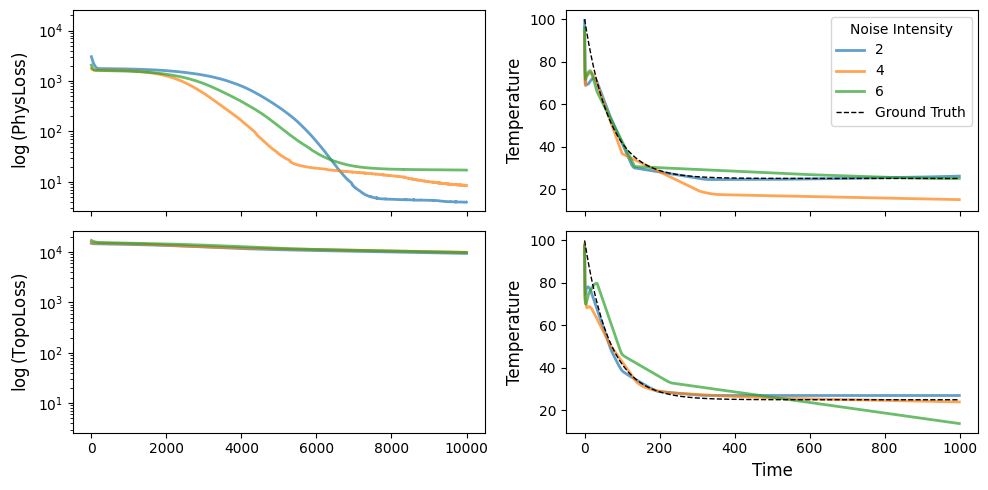

In [25]:
fig, ax = plt.subplots(2, 2, figsize = (10, 5 ), sharex='col', sharey='col')
for record in noise_records:
    xs = range(len(record['losses']))
    ys = range(len(record['prediction']))
    if record['phys_loss']:
        ax[0, 0].plot(xs, record['losses'], label = record['noise_intensity'], lw = 2, alpha = 0.7)
        ax[0, 1].plot(ys, record['prediction'].numpy().flatten(), label = record['noise_intensity'], lw = 2, alpha = 0.7)
    else:
        ax[1, 0].plot(xs, record['losses'], label = record['noise_intensity'], lw = 2, alpha = 0.7)
        ax[1, 1].plot(ys, record['prediction'].numpy().flatten(), label = record['noise_intensity'], lw = 2, alpha = 0.7)

ax[0, 0].set_ylabel("$\log$(PhysLoss)", fontsize = 12)
ax[0, 0].set_yscale('log')
ax[1, 0].set_ylabel("$\log$(TopoLoss)", fontsize = 12)
ax[1, 0].set_yscale('log')

ax[0, 1].set_ylabel('Temperature', fontsize = 12)
ax[0, 1].plot(record['times'], cooling.true_temps, label = 'Ground Truth', lw = 1, color = 'black', linestyle = '--')
ax[0, 1].legend(title = 'Noise Intensity')
ax[1, 1].set_ylabel('Temperature', fontsize = 12)
ax[1, 1].set_xlabel("Time", fontsize = 12)
ax[1, 1].plot(record['times'], cooling.true_temps, label = 'Ground Truth', lw = 1, color = 'black', linestyle = '--')
plt.tight_layout()
#plt.savefig("./imgs/cooling_law_with_diff_losses.png")
plt.show()